# Aug19th Madrasin Data: featureCounts Compare Exon-Intron Boundaries: Madrasin Vs Controls

## Purpose

This were read counts generated by the program featureCounts After Bowtie2 Alignment

Aim of this script is to get the ratio of Madrasin vs Controls in exon-intron boundaries for samples that were both treated and not treated with DMS

We want to see how the ratio changes as you add varying concentrations of Madrasin

The data in this script is from sequencing data collected by Lela in August 19th weekend 2018. The tmp folder is Lela_20uM_MadrasinReadsTest_August2018

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Load R GGplots
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(reshape)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: reshape

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [4]:
# Set variable to remove non-coding genes
removeNC=False
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../processed_data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [5]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../processed_data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [7]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [8]:
# which end
whichend=str(5)

In [9]:
# Get highly expressed features from each file for the transcriptome data
top_features_data = []
for filename in os.listdir("../tmp/Lela_20uM_MadrasinReadsTest_August2018/"):
    if ("ExonIntron"+whichend+"p_featureCounts_JustCounts.txt" in filename):
        print filename
        # Read the salmon output file
        with open("../tmp/Lela_20uM_MadrasinReadsTest_August2018/"+filename) as f:
            lines = f.readlines()
        with open("../tmp/Lela_20uM_MadrasinReadsTest_August2018/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        data_to_read = pd.read_csv("../tmp/Lela_20uM_MadrasinReadsTest_August2018/"+filename.split('.')[0]+"_DropHeader.txt",header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        # Sort the data by TPMs
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_data.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_data.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

Madrasin-20uM-4hr-Minus-2_S5_ExonIntron5p_featureCounts_JustCounts.txt
Madrasin-20uM-4hr-Plus-1_S1_ExonIntron5p_featureCounts_JustCounts.txt
Madrasin-20uM-8hr-Minus_S4_ExonIntron5p_featureCounts_JustCounts.txt
Untreated-Minus_S7_ExonIntron5p_featureCounts_JustCounts.txt
Madrasin-20uM-4hr-Plus-2_S6_ExonIntron5p_featureCounts_JustCounts.txt
Madrasin-20uM-4hr-Minus-1_S2_ExonIntron5p_featureCounts_JustCounts.txt
Madrasin-20uM-8hr-Plus_S3_ExonIntron5p_featureCounts_JustCounts.txt
Untreated-Plus_S8_ExonIntron5p_featureCounts_JustCounts.txt


In [10]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_data))
print(len(unique_top_features))

114


In [11]:
# Create a data frame with unique top features as column
feature_readCounts_Data = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_20uM_MadrasinReadsTest_August2018/"):
    current_columns = list(feature_readCounts_Data.columns.values)
    if ("ExonIntron"+whichend+"p_featureCounts_JustCounts_DropHeader.txt" in filename):
        print filename
        current_columns.append(filename.split("_ExonIntron")[0])
        data_to_read = pd.read_csv("../tmp/Lela_20uM_MadrasinReadsTest_August2018/"+filename,header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_Data = pd.concat([feature_readCounts_Data,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_Data.columns = current_columns

Madrasin-20uM-4hr-Minus-1_S2_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Madrasin-20uM-4hr-Plus-1_S1_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Untreated-Minus_S7_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Madrasin-20uM-4hr-Plus-2_S6_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Madrasin-20uM-4hr-Minus-2_S5_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Untreated-Plus_S8_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Madrasin-20uM-8hr-Minus_S4_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt
Madrasin-20uM-8hr-Plus_S3_ExonIntron5p_featureCounts_JustCounts_DropHeader.txt


In [12]:
feature_readCounts_Data = feature_readCounts_Data.iloc[:,range(1,feature_readCounts_Data.shape[1])]
feature_readCounts_Data.index = sorted(unique_top_features)
print feature_readCounts_Data.shape
feature_readCounts_Data.head()

(114, 8)


,Madrasin-20uM-4hr-Minus-1_S2,Madrasin-20uM-4hr-Plus-1_S1,Untreated-Minus_S7,Madrasin-20uM-4hr-Plus-2_S6,Madrasin-20uM-4hr-Minus-2_S5,Untreated-Plus_S8,Madrasin-20uM-8hr-Minus_S4,Madrasin-20uM-8hr-Plus_S3
ACTB,7825.027484,8628.956080,8587.633417,12317.735150,8130.027741,10350.868035,6400.161068,7755.068899
ACTG1,1645.085249,2880.802792,2894.950636,4627.013468,3350.879643,6497.698757,1820.423172,2299.384579
APEX1,1031.654204,184.733875,608.134696,270.662377,425.279265,192.029506,800.939697,228.033060
ARL6IP5,956.864774,199.898596,82.257025,230.120731,690.285374,249.351746,266.673378,299.627662
ARPC2,974.584492,546.944771,575.799175,481.161529,703.068437,507.938742,866.688478,646.255742


In [14]:
sorted_columns = sorted(list(feature_readCounts_Data.columns.values))
columns_DMSPlus_Madrasin = [i for i in sorted_columns if "Plus" in i and "Madrasin" in i]
columns_DMSMinus_Madrasin = [i for i in sorted_columns if "Minus" in i and "Madrasin" in i]

In [16]:
feature_readCounts_Data_MadrasinData_PlusDMS = feature_readCounts_Data[columns_DMSPlus_Madrasin]
print feature_readCounts_Data_MadrasinData_PlusDMS.shape
feature_readCounts_Data_MadrasinData_PlusDMS.head()

(114, 3)


,Madrasin-20uM-4hr-Plus-1_S1,Madrasin-20uM-4hr-Plus-2_S6,Madrasin-20uM-8hr-Plus_S3
ACTB,8628.956080,12317.735150,7755.068899
ACTG1,2880.802792,4627.013468,2299.384579
APEX1,184.733875,270.662377,228.033060
ARL6IP5,199.898596,230.120731,299.627662
ARPC2,546.944771,481.161529,646.255742


In [17]:
# Let's get ratios of feature counts for Madrasin vs non Madrasin for plus DMS
ratios_readCounts_PlusDMS = feature_readCounts_Data_MadrasinData_PlusDMS.divide(feature_readCounts_Data["Untreated-Plus_S8"],axis=0)
print ratios_readCounts_PlusDMS.shape
ratios_readCounts_PlusDMS.head()

(114, 3)


,Madrasin-20uM-4hr-Plus-1_S1,Madrasin-20uM-4hr-Plus-2_S6,Madrasin-20uM-8hr-Plus_S3
ACTB,0.833646,1.190020,0.749219
ACTG1,0.443357,0.712100,0.353877
APEX1,0.962008,1.409483,1.187490
ARL6IP5,0.801673,0.922876,1.201626
ARPC2,1.076793,0.947283,1.272310


In [19]:
feature_readCounts_Data_MadrasinData_MinusDMS = feature_readCounts_Data[columns_DMSMinus_Madrasin]
print feature_readCounts_Data_MadrasinData_MinusDMS.shape
feature_readCounts_Data_MadrasinData_MinusDMS.head()

(114, 3)


,Madrasin-20uM-4hr-Minus-1_S2,Madrasin-20uM-4hr-Minus-2_S5,Madrasin-20uM-8hr-Minus_S4
ACTB,7825.027484,8130.027741,6400.161068
ACTG1,1645.085249,3350.879643,1820.423172
APEX1,1031.654204,425.279265,800.939697
ARL6IP5,956.864774,690.285374,266.673378
ARPC2,974.584492,703.068437,866.688478


In [20]:
# Let's get ratios of feature counts for Madrasin vs non Madrasin for minus DMS
ratios_readCounts_MinusDMS = feature_readCounts_Data_MadrasinData_MinusDMS.divide(feature_readCounts_Data["Untreated-Minus_S7"],axis=0)
print ratios_readCounts_MinusDMS.shape
ratios_readCounts_MinusDMS.head()

(114, 3)


,Madrasin-20uM-4hr-Minus-1_S2,Madrasin-20uM-4hr-Minus-2_S5,Madrasin-20uM-8hr-Minus_S4
ACTB,0.911197,0.946713,0.745276
ACTG1,0.568260,1.157491,0.628827
APEX1,1.696424,0.699318,1.317043
ARL6IP5,11.632621,8.391811,3.241953
ARPC2,1.692577,1.221031,1.505192


[1] "../results/Lela_20uM_MadrasinReadsTest_August2018/GGplot2-FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_5pExonIntronBoundaries_All_50MostHighlyExpressedGenesWithIntronicRegions.png"


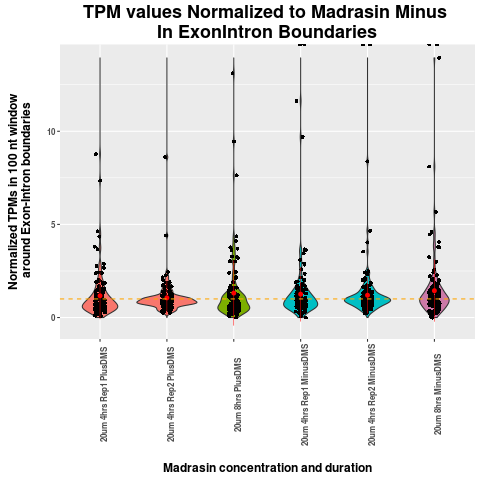

In [39]:
%%R -i ratios_readCounts_MinusDMS,ratios_readCounts_PlusDMS,whichend,numFeatures,removeNC_string,feature,featuresWithIntrons_string
data=cbind(ratios_readCounts_PlusDMS,ratios_readCounts_MinusDMS)
data$ID = row.names(data)
melted_data <- melt(data, id=c("ID"))
p <- ggplot(melted_data, aes(x=variable, y=value,fill=variable)) +
    #geom_boxplot() + 
    geom_violin(trim=FALSE) +
    geom_jitter(shape=16, position=position_jitter(0.2)) + 
    stat_summary(fun.y = mean,fun.ymin = function(x) mean(x) - sd(x),fun.ymax = function(x) mean(x) + sd(x),geom = "pointrange", size=0.25, color="red") +
    geom_hline(yintercept=1, linetype="dashed", color = "orange") +
    scale_fill_manual(values=c("#F8766D", "#F8766D","#7CAE00","#00BFC4", "#00BFC4","#CC79A7")) +
    xlab("\nMadrasin concentration and duration") +
    ylab("Normalized TPMs in 100 nt window\n around Exon-Intron boundaries\n") +
    scale_x_discrete(labels=c("20um 4hrs Rep1 PlusDMS", "20um 4hrs Rep2 PlusDMS", "20um 8hrs PlusDMS","20um 4hrs Rep1 MinusDMS", 
                              "20um 4hrs Rep2 MinusDMS", "20um 8hrs MinusDMS")) +
    ggtitle("TPM values Normalized to Madrasin Minus \nIn ExonIntron Boundaries") + 
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(angle = 90, face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         legend.position="none",plot.title = element_text(face="bold",size=18))
filenameToSave = paste("../results/Lela_20uM_MadrasinReadsTest_August2018/GGplot2-FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_",whichend,"pExonIntronBoundaries_All_",numFeatures,"MostHighlyExpressed",removeNC_string,feature,"s",featuresWithIntrons_string,".png",sep="")
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

[1] "../results/Lela_20uM_MadrasinReadsTest_August2018/GGplot2-FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_5pExonIntronBoundaries_PlusDMS_50MostHighlyExpressedGenesWithIntronicRegions.png"


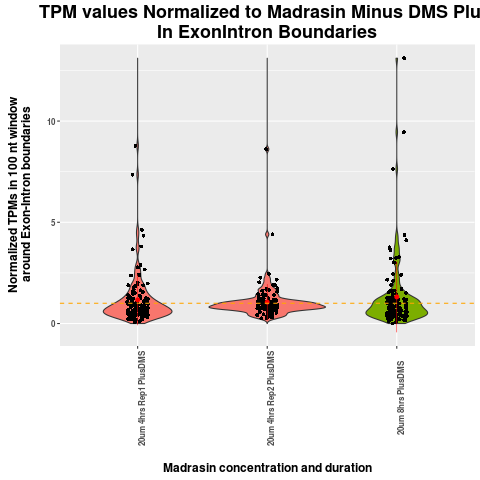

In [40]:
%%R -i ratios_readCounts_PlusDMS,whichend,numFeatures,removeNC_string,feature,featuresWithIntrons_string
data=ratios_readCounts_PlusDMS
data$ID = row.names(data)
melted_data <- melt(data, id=c("ID"))
p <- ggplot(melted_data, aes(x=variable, y=value,fill=variable)) +
    #geom_boxplot() + 
    geom_violin(trim=FALSE) +
    geom_jitter(shape=16, position=position_jitter(0.2)) + 
    stat_summary(fun.y = mean,fun.ymin = function(x) mean(x) - sd(x),fun.ymax = function(x) mean(x) + sd(x),geom = "pointrange", size=0.25, color="red") +
    geom_hline(yintercept=1, linetype="dashed", color = "orange") +
    scale_fill_manual(values=c("#F8766D", "#F8766D","#7CAE00")) +
    xlab("\nMadrasin concentration and duration") +
    ylab("Normalized TPMs in 100 nt window\n around Exon-Intron boundaries\n") +
    scale_x_discrete(labels=c("20um 4hrs Rep1 PlusDMS", "20um 4hrs Rep2 PlusDMS", "20um 8hrs PlusDMS")) +
    ggtitle("TPM values Normalized to Madrasin Minus DMS Plus \nIn ExonIntron Boundaries") + 
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(angle = 90, face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         legend.position="none",plot.title = element_text(face="bold",size=18))
filenameToSave = paste("../results/Lela_20uM_MadrasinReadsTest_August2018/GGplot2-FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_",whichend,"pExonIntronBoundaries_PlusDMS_",numFeatures,"MostHighlyExpressed",removeNC_string,feature,"s",featuresWithIntrons_string,".png",sep="")
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

[1] "../results/Lela_20uM_MadrasinReadsTest_August2018/GGplot2-FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_5pExonIntronBoundaries_MinusDMS_50MostHighlyExpressedGenesWithIntronicRegions.png"


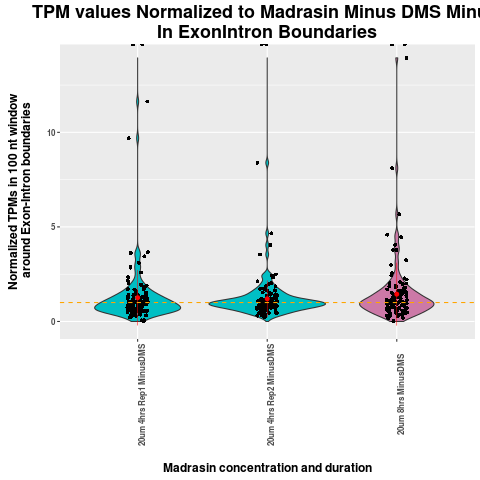

In [41]:
%%R -i ratios_readCounts_MinusDMS,whichend,numFeatures,removeNC_string,feature,featuresWithIntrons_string
data=ratios_readCounts_MinusDMS
data$ID = row.names(data)
melted_data <- melt(data, id=c("ID"))
p <- ggplot(melted_data, aes(x=variable, y=value,fill=variable)) +
    #geom_boxplot() + 
    geom_violin(trim=FALSE) +
    geom_jitter(shape=16, position=position_jitter(0.2)) + 
    stat_summary(fun.y = mean,fun.ymin = function(x) mean(x) - sd(x),fun.ymax = function(x) mean(x) + sd(x),geom = "pointrange", size=0.25, color="red") +
    geom_hline(yintercept=1, linetype="dashed", color = "orange") +
    scale_fill_manual(values=c("#00BFC4", "#00BFC4","#CC79A7")) +
    xlab("\nMadrasin concentration and duration") +
    ylab("Normalized TPMs in 100 nt window\n around Exon-Intron boundaries\n") +
    scale_x_discrete(labels=c("20um 4hrs Rep1 MinusDMS","20um 4hrs Rep2 MinusDMS", "20um 8hrs MinusDMS")) +
    ggtitle("TPM values Normalized to Madrasin Minus DMS Minus \nIn ExonIntron Boundaries") + 
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(angle = 90, face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         legend.position="none",plot.title = element_text(face="bold",size=18))
filenameToSave = paste("../results/Lela_20uM_MadrasinReadsTest_August2018/GGplot2-FeatureCounts_MeanRatio_MadrasinVsNoMadrasin_",whichend,"pExonIntronBoundaries_MinusDMS_",numFeatures,"MostHighlyExpressed",removeNC_string,feature,"s",featuresWithIntrons_string,".png",sep="")
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p